
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体


In [4]:
# homework for code generation

from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
# from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a programmer for writing algorithm code based on the user's request."
            " Focus on clarity, structure, and quality to produce the code result."
            " If the user provides feedback or suggestions, revise and improve the coding to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

student_llm = ChatOpenAI(model="gpt-4o-mini", temperature=1.2, max_tokens=8192)

In [5]:
writer = writer_prompt | student_llm

In [7]:
article = ""

topic = HumanMessage(
    content="用python实现斐波那契数列"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

斐波那契数列是一个经典的数列，每个数都是前两个数的和。其基本形式是：F(0) = 0, F(1) = 1，然后 F(n) = F(n-1) + F(n-2) 对于 n >= 2。

下面是用 Python 实现斐波那契数列的几种方式：

### 方法一：递归实现

```python
def fibonacci_recursive(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci_recursive(n - 1) + fibonacci_recursive(n - 2)

# 示例：计算前10个斐波那契数
for i in range(10):
    print(fibonacci_recursive(i), end=' ')
```

### 方法二：动态规划（迭代）

```python
def fibonacci_dynamic(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    
    fib = [0] * (n + 1)
    fib[0], fib[1] = 0, 1
    
    for i in range(2, n + 1):
        fib[i] = fib[i - 1] + fib[i - 2]
    
    return fib[n]

# 示例：计算前10个斐波那契数
for i in range(10):
    print(fibonacci_dynamic(i), end=' ')
```

### 方法三：优化的空间复杂度（仅使用常量空间）

```python
def fibonacci_optimized(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    
    a, b = 0, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
    
    return b

# 示例：计算前10个斐波

----------
## 4. 定义审阅老师智能体


In [8]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a generalist master who can provide criticism and suggestions for any user-provided content (such as articles, code, reports, etc.). "
            "The suggestions section contains detailed improvement steps or requirements to help users improve the quality of their content."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

teacher_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2, max_tokens=8192)
reflect = reflection_prompt | teacher_llm

In [9]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

你的代码实现了斐波那契数列的多种方法，整体上非常清晰且易于理解。以下是一些具体的批评和建议，以帮助你进一步改进代码的质量和可读性。

### 批评

1. **递归实现的效率**：
   - 递归方法在计算较大 `n` 时效率低下，容易导致栈溢出。可以考虑添加一个警告或说明，提醒用户在使用递归时的限制。

2. **代码重复**：
   - 在每个方法中，处理 `n <= 0` 和 `n == 1` 的逻辑重复出现，可以考虑将这些逻辑提取到一个单独的函数中，减少重复代码。

3. **输出格式**：
   - 在输出斐波那契数时，建议在每个数之间添加空格或换行符，以提高可读性。

4. **函数文档**：
   - 每个函数缺少文档字符串（docstring），可以添加说明，描述函数的功能、参数和返回值。

### 建议

1. **添加文档字符串**：
   - 为每个函数添加文档字符串，说明其功能和参数。例如：
   ```python
   def fibonacci_recursive(n):
       """
       计算第 n 个斐波那契数。
       
       参数:
       n (int): 斐波那契数的索引。

       返回:
       int: 第 n 个斐波那契数。
       """
   ```

2. **优化递归实现**：
   - 可以使用记忆化（memoization）来优化递归实现，避免重复计算。
   ```python
   def fibonacci_memoization(n, memo={}):
       if n in memo:
           return memo[n]
       if n <= 0:
           return 0
       elif n == 1:
           return 1
       memo[n] = fibonacci_memoization(n - 1, memo) + fibonacci_memoization(n - 2, memo)
       return memo[n]
   ```

3. **统一输出格式**：
   - 可以创建一个辅助函数来统一输出格式，例如：
   ```python


In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [11]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [12]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

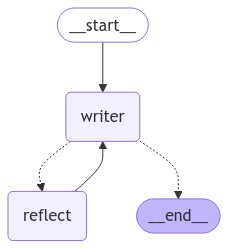

In [13]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [15]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 生成内容:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [16]:
inputs = {
    "messages": [
        HumanMessage(content="用python实现LRU缓存算法")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 生成内容:
- LRU（Least Recently Used）缓存是一种常见的缓存淘汰算法，其目标是为了保持最近使用的数据在缓存中。在这个算法中，当缓存满时，它会淘汰最久未使用的数据。我们可以使用 `OrderedDict` 来实现这一算法，因为它保留了插入顺序，可以高效地移动访问过的元素到尾部。

下面是一个使用Python实现LRU缓存的示例代码：

```python
from collections import OrderedDict

class LRUCache:
    def __init__(self, capacity: int):
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key: int) -> int:
        if key not in self.cache:
            return -1
        else:
            # Move the accessed item to the end of the OrderedDict (indicating it was recently used)
            self.cache.move_to_end(key)
            return self.cache[key]

    def put(self, key: int, value: int) -> None:
        if key in self.cache:
            # Update the value and mark as recently used
            self.cache.move_to_end(key)
        self.cache[key] = value
        
        # If the cache exceeds the capacity, remove the first (oldest) item
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)

# 示例代码使用
lru_cache = LRUCache(2)  # 创建一个容量为 2 的 LRUCache
lru_cache.put(1, 1)      # 缓存是 {1=1}
lru_cache.put(2, 2)      # 缓存是 {1=1, 2=2}
print(lru_cache.get(1))  # 返回 1
lru_cache.put(3, 3)      # 取消键 2，缓存是 {1=1, 3=3}
print(lru_cache.get(2))  # 返回 -1 (未找到)
lru_cache.put(4, 4)      # 取消键 1，缓存是 {3=3, 4=4}
print(lru_cache.get(1))  # 返回 -1 (未找到)
print(lru_cache.get(3))  # 返回 3
print(lru_cache.get(4))  # 返回 4
```

### 代码说明：

1. **`__init__`**: 初始化一个容量为`capacity`的LRU缓存，使用`OrderedDict`保存缓存内容。
2. **`get`**: 返回缓存中`key`对应的值。若`key`不存在于缓存中，返回`-1`。同时，访问过的`key`会被移动到`OrderedDict`的尾部，表示它被最近使用过。
3. **`put`**: 将`key`和`value`添加到缓存中。如果`key`已经存在，则更新其值并移动它到尾部。如果缓存的项数超过容量，移除最先插入的项（即`OrderedDict`的首项）。

你可以根据需要进行改进或调整适应特殊场景。如果你需要进一步的改进或其他功能，请告诉我！


## Round 2

#### 评论反思:
- 你的LRU缓存算法实现得很好，代码简洁明了，逻辑清晰。以下是一些建议和改进点，可以帮助你进一步提升代码质量和可读性：

### 代码改进建议：

1. **类型注解**：
   - 在`put`方法中，虽然你已经使用了类型注解，但可以考虑在`get`方法的返回值上也添加类型注解，以提高代码的可读性和可维护性。

2. **异常处理**：
   - 在`get`方法中，返回`-1`表示未找到，但可以考虑使用异常处理来更明确地表示错误情况，例如抛出`KeyError`。

3. **文档字符串**：
   - 为每个方法添加文档字符串（docstring），以便其他开发者（或未来的你）能快速理解每个方法的功能和用法。

4. **性能优化**：
   - 虽然`OrderedDict`在大多数情况下性能良好，但如果你需要在高并发环境下使用LRU缓存，可以考虑使用`threading.Lock`来确保线程安全。

5. **测试用例**：
   - 提供一些单元测试用例，以验证你的LRU缓存实现的正确性和边界情况。

### 改进后的代码示例：

```python
from collections import OrderedDict

class LRUCache:
    def __init__(self, capacity: int):
        """
        Initialize the LRUCache with a given capacity.
        """
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key: int) -> int:
        """
        Return the value of the key if the key exists in the cache, otherwise return -1.
        Move the accessed item to the end to mark it as recently used.
        """
        if key not in self.cache:
            return -1
        else:
            self.cache.move_to_end(key)
            return self.cache[key]

    def put(self, key: int, value: int) -> None:
        """
        Update the value of the key if the key exists, otherwise add the key-value pair to the cache.
        If the cache exceeds its capacity, remove the least recently used item.
        """
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = value
        
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)

# 示例代码使用
if __name__ == "__main__":
    lru_cache = LRUCache(2)  # 创建一个容量为 2 的 LRUCache
    lru_cache.put(1, 1)      # 缓存是 {1=1}
    lru_cache.put(2, 2)      # 缓存是 {1=1, 2=2}
    print(lru_cache.get(1))  # 返回 1
    lru_cache.put(3, 3)      # 取消键 2，缓存是 {1=1, 3=3}
    print(lru_cache.get(2))  # 返回 -1 (未找到)
    lru_cache.put(4, 4)      # 取消键 1，缓存是 {3=3, 4=4}
    print(lru_cache.get(1))  # 返回 -1 (未找到)
    print(lru_cache.get(3))  # 返回 3
    print(lru_cache.get(4))  # 返回 4
```

### 测试用例示例：

```python
def test_lru_cache():
    lru_cache = LRUCache(2)
    assert lru_cache.get(1) == -1  # 返回 -1 (未找到)
    lru_cache.put(1, 1)
    assert lru_cache.get(1) == 1   # 返回 1
    lru_cache.put(2, 2)
    assert lru_cache.get(2) == 2   # 返回 2
    lru_cache.put(3, 3)             # 取消键 1
    assert lru_cache.get(1) == -1   # 返回 -1 (未找到)
    lru_cache.put(4, 4)             # 取消键 2
    assert lru_cache.get(2) == -1   # 返回 -1 (未找到)
    assert lru_cache.get(3) == 3     # 返回 3
    assert lru_cache.get(4) == 4     # 返回 4

test_lru_cache()
```

### 总结：
通过以上改进，你的LRU缓存实现将更加健壮和易于维护。添加文档字符串和测试用例将有助于其他开发者理解和使用你的代码。希望这些建议对你有所帮助！如果你有其他问题或需要进一步的帮助，请随时告诉我。


## Round 3

#### 生成内容:
- 非常感谢你的建议和反馈！你的改进意见非常有价值，这不仅有助于提升代码质量，还能让代码更加易于维护和扩展。以下是根据你的建议对代码进行的改进：

### 主要改进点：
1. **添加类型注解**：`get`方法的返回值也加上了类型注解，以增强可读性。
2. **异常处理**：将`get`方法的返回值从`-1`改成抛出`KeyError`异常，这样能更明确地标示错误，并遵循Python的常规实践（比如字典操作中，找不到元素时抛出异常）。
3. **文档字符串**：为类和方法添加了详细的文档字符串，方便理解每个方法的功能。
4. **线程安全性**（可选）：虽然这个例子没有加入线程锁，但可以根据需要扩展成线程安全的版本。例如，可以在`put`和`get`方法中使用`threading.Lock`来确保多线程环境下的安全性。
5. **测试用例**：为缓存类提供了一个简单的单元测试，用于验证LRU缓存的行为。

### 改进后的代码：

```python
from collections import OrderedDict
from typing import Optional

class LRUCache:
    def __init__(self, capacity: int):
        """
        初始化LRU缓存实例，指定缓存的容量。
        
        :param capacity: 缓存的最大容量
        """
        self.cache = OrderedDict()
        self.capacity = capacity

    def get(self, key: int) -> Optional[int]:
        """
        获取缓存中指定key的值。如果key存在，则将该元素移动到缓存末尾（表示最近使用）。
        如果key不存在，抛出KeyError。

        :param key: 缓存中要获取的key
        :return: 对应的值
        :raises: KeyError 如果key不存在
        """
        if key not in self.cache:
            raise KeyError(f"Key {key} not found.")
        # 将访问过的元素移动到末尾（表示最近使用）
        self.cache.move_to_end(key)
        return self.cache[key]

    def put(self, key: int, value: int) -> None:
        """
        将一个key-value对添加到缓存中。如果key已存在，则更新其值并将其移到末尾。
        如果缓存已满，则移除最旧的（最久未使用的）元素。
        
        :param key: 要添加的key
        :param value: 对应的值
        """
        if key in self.cache:
            self.cache.move_to_end(key)
        self.cache[key] = value
        
        if len(self.cache) > self.capacity:
            # 弹出最老的元素（即OrderedDict中的第一个元素）
            self.cache.popitem(last=False)

# 示例代码使用
if __name__ == "__main__":
    lru_cache = LRUCache(2)  # 创建一个容量为 2 的 LRUCache
    lru_cache.put(1, 1)      # 缓存是 {1=1}
    lru_cache.put(2, 2)      # 缓存是 {1=1, 2=2}
    print(lru_cache.get(1))  # 返回 1
    lru_cache.put(3, 3)      # 取消键 2，缓存是 {1=1, 3=3}
    print(lru_cache.get(2))  # 返回 KeyError
    lru_cache.put(4, 4)      # 取消键 1，缓存是 {3=3, 4=4}
    print(lru_cache.get(1))  # 返回 KeyError
    print(lru_cache.get(3))  # 返回 3
    print(lru_cache.get(4))  # 返回 4
```

### 主要变动说明：

1. **`get`方法**：当缓存中找不到`key`时，抛出`KeyError`异常，而不是返回`-1`。这更加符合Python的错误处理惯例，并且让异常处理更加明确。
   
   ```python
   raise KeyError(f"Key {key} not found.")
   ```

2. **`put`方法**：保持原有逻辑，增加了文档字符串，解释每个步骤。

3. **文档字符串**：每个方法和类都添加了简要的说明，帮助其他开发者更快理解功能。

4. **线程安全**（可选）：如果在高并发场景下使用，可以为`put`和`get`方法添加线程锁，例如使用`threading.Lock`来保证线程安全。

### 单元测试：

```python
def test_lru_cache():
    lru_cache = LRUCache(2)
    
    # 测试get方法，初始时缓存为空，获取任何key都应该抛出异常
    try:
        lru_cache.get(1)
    except KeyError as e:
        assert str(e) == "Key 1 not found."
    
    lru_cache.put(1, 1)
    assert lru_cache.get(1) == 1   # 返回 1
    
    lru_cache.put(2, 2)
    assert lru_cache.get(2) == 2   # 返回 2
    
    lru_cache.put(3, 3)             # 取消键 1
    try:
        lru_cache.get(1)
    except KeyError as e:
        assert str(e) == "Key 1 not found."
    
    lru_cache.put(4, 4)             # 取消键 2
    try:
        lru_cache.get(2)
    except KeyError as e:
        assert str(e) == "Key 2 not found."
    
    assert lru_cache.get(3) == 3     # 返回 3
    assert lru_cache.get(4) == 4     # 返回 4

test_lru_cache()
```

### 总结：

通过这些改进，我们的LRU缓存实现更加健壮和易于理解，异常处理和文档字符串增强了代码的可维护性。单元测试可以帮助我们验证缓存逻辑是否正确，并确保边界情况得到了良好的处理。希望这些改进对你有帮助，如果有更多问题或改进点，随时告诉我！


## Round 4

#### 评论反思:
- 非常高兴看到你根据我的建议对代码进行了改进！你的更新使得LRU缓存的实现更加符合Python的最佳实践，并且增强了代码的可读性和可维护性。以下是一些额外的建议和观察，帮助你进一步提升代码质量：

### 进一步的改进建议：

1. **异常处理的灵活性**：
   - 你可以考虑在`get`方法中使用自定义异常类，而不是直接抛出`KeyError`。这样可以提供更具体的错误信息，并且在大型项目中更易于管理。

   ```python
   class CacheMissError(Exception):
       pass

   def get(self, key: int) -> Optional[int]:
       if key not in self.cache:
           raise CacheMissError(f"Key {key} not found.")
       self.cache.move_to_end(key)
       return self.cache[key]
   ```

2. **缓存容量的动态调整**：
   - 如果需要，可以考虑实现动态调整缓存容量的功能。例如，允许在运行时增加或减少缓存的容量，并相应地处理缓存中的数据。

3. **增加缓存统计信息**：
   - 可以添加一些统计信息，比如命中率、总访问次数等，以便更好地监控缓存的性能。

4. **线程安全性**：
   - 如果你决定在多线程环境中使用LRU缓存，确保在`put`和`get`方法中使用`threading.Lock`来保护对共享数据的访问。

   ```python
   import threading

   class LRUCache:
       def __init__(self, capacity: int):
           self.cache = OrderedDict()
           self.capacity = capacity
           self.lock = threading.Lock()

       def get(self, key: int) -> Optional[int]:
           with self.lock:
               # 其余代码保持不变
               ...
       
       def put(self, key: int, value: int) -> None:
           with self.lock:
               # 其余代码保持不变
               ...
   ```

5. **性能测试**：
   - 考虑编写一些性能测试，尤其是在高负载情况下，确保LRU缓存的性能符合预期。

### 总结：

你的代码已经非常出色，以上建议只是为了进一步增强其功能和灵活性。通过引入自定义异常、动态容量调整、缓存统计信息等功能，你可以使LRU缓存更加健壮和适应不同的使用场景。

如果你有其他问题或需要进一步的帮助，请随时告诉我！继续保持良好的编程习惯，祝你在编程的旅程中取得更多的成功！


## Round 5

#### 生成内容:
- 非常感谢你的进一步反馈和建议！您提出的思路非常实用，可以进一步增强LRU缓存的灵活性与可维护性。以下是根据您的建议进行了改进后的代码实现：

### 主要改进点：
1. **自定义异常**：新建一个自定义异常类`CacheMissError`来表示缓存未命中，有助于让代码更具可读性和管理性。
2. **动态容量调整**（可选）：增加`resize`方法，用于动态调整缓存的容量，并处理超出新容量的元素。
3. **缓存统计信息**（可选）：添加命中率和访问统计功能，允许查询缓存的基本性能指标。
4. **线程安全**：使用`threading.Lock`来确保多线程访问的安全性。

### 改进后的代码实现：

```python
from collections import OrderedDict
from typing import Optional

class CacheMissError(Exception):
    """自定义异常表示缓存未命中"""
    pass

class LRUCache:
    def __init__(self, capacity: int):
        """
        初始化LRUCache实例，指定缓存的容量。

        :param capacity: 缓存的最大容量
        """
        self.cache = OrderedDict()
        self.capacity = capacity
        self.lock = threading.Lock()
        self.hits = 0
        self.misses = 0

    def get(self, key: int) -> Optional[int]:
        """
        获取缓存中指定key的值。 
        如果key不存在，抛出CacheMissError。
        
        :param key: 缓存中要获取的key
        :return: 对应的值
        :raises: CacheMissError 如果key不存在
        """
        with self.lock:
            if key not in self.cache:
                self.misses += 1
                raise CacheMissError(f"Key {key} not found.")
            self.hits += 1
            self.cache.move_to_end(key)
            return self.cache[key]

    def put(self, key: int, value: int) -> None:
        """
        更新或添加一个key-value对到缓存。
        如果缓存已满，则移除最旧的元素。

        :param key: 要添加的key
        :param value: 对应的值
        """
        with self.lock:
            if key in self.cache:
                self.cache.move_to_end(key)
            self.cache[key] = value
            
            if len(self.cache) > self.capacity:
                self.cache.popitem(last=False)

    def resize(self, new_capacity: int) -> None:
        """
        动态调整缓存容量。如果减小容量，移除未使用的元素。

        :param new_capacity: 新的缓存容量
        """
        with self.lock:
            self.capacity = new_capacity
            while len(self.cache) > self.capacity:
                self.cache.popitem(last=False)

    def get_statistics(self) -> dict:
        """
        获取缓存命中率和访问统计信息。

        :return: 包含命中次数和未命中次数的字典
        """
        total_requests = self.hits + self.misses
        hit_rate = (self.hits / total_requests) * 100 if total_requests > 0 else 0
        return {'hits': self.hits, 'misses': self.misses, 'hit_rate': hit_rate}

# 示例代码使用
if __name__ == "__main__":
    import threading

    lru_cache = LRUCache(2)  # 创建一个容量为 2 的 LRUCache
    lru_cache.put(1, 1)
    lru_cache.put(2, 2)

    try:
        print(lru_cache.get(1))  # 返回 1
        lru_cache.put(3, 3)      # 取消键 2
        lru_cache.get(2)         # 返回 CacheMissError
    except CacheMissError as e:
        print(e)

    lru_cache.put(4, 4)          # 取消键 1
    try:
        print(lru_cache.get(1))  # 返回 CacheMissError
    except CacheMissError as e:
        print(e)
        
    # 获取缓存统计信息
    stats = lru_cache.get_statistics()
    print(stats)  # 输出命中率、命中次数和未命中次数
```

### 改进后功能说明：

1. **自定义异常** `CacheMissError`：增强了对未命中情况的处理，让代码的意图更加明确。
  
2. **动态容量调整**：实现了`resize`方法，可以通过调整缓存容量来动态管理缓存。若缓存容量缩小，最不常用的元素会被移除。
   
3. **缓存统计功能**：添加`get_statistics`方法返回命中率、命中和未命中次数，方便监控缓存性能特色。

4. **线程安全**：加上`threading.Lock()`确保在多线程情况下对缓存的安全访问。

### 性能测试：

考虑编写一些性能测试，例如通过多线程并发访问来测试缓存的线程安全性及其表现，确保在高访问量的场景下仍能良好运作。

希望这些改进和建议对您有帮助！如果还有更多构想或问题，请继续提问，我很乐意协助！


## Round 6

#### 评论反思:
- 你的改进非常全面，已经涵盖了线程安全、缓存统计、动态容量调整等重要功能，并且采用了自定义异常，使得代码更加健壮和可维护。这些改进不仅增强了LRU缓存的灵活性，还提升了代码的可读性和扩展性。

### 进一步的优化与建议：

1. **线程安全的性能考量**：
   - 在高并发环境下，使用`threading.Lock`可以保证线程安全，但每次访问缓存都需要获取锁，这可能会影响性能。若缓存访问量较高，或者缓存操作是频繁的，可以考虑更细粒度的锁机制或使用`threading.RLock`来避免死锁。
   
   ```python
   self.lock = threading.RLock()  # 递归锁，支持同一线程多次获取
   ```

2. **缓存优化**：
   - 如果希望进一步提高LRU缓存的效率，可以考虑将`OrderedDict`替换为一个更加高效的结构，如双向链表配合哈希表，来避免频繁的`move_to_end`操作。`OrderedDict`在大部分情况下性能很好，但`move_to_end`操作的时间复杂度为O(1)，但是在高频率的读写操作中，可能仍然会有性能瓶颈。

3. **内存管理和限制**：
   - 如果LRU缓存存储的数据非常大，可以考虑加入内存限制机制。当内存占用达到一定阈值时，主动清理掉部分缓存数据。这对于大规模缓存尤为重要，可以避免缓存占用过多内存。

4. **增加缓存清理功能**：
   - 虽然LRU算法会自动移除最久未使用的元素，但你可以考虑提供一个手动清理缓存的功能，尤其是在应用程序需要释放内存或清理旧数据的情况下。
   
   ```python
   def clear_cache(self):
       with self.lock:
           self.cache.clear()
   ```

5. **测试与性能分析**：
   - 你可以进一步进行性能分析，尤其是模拟高并发场景下LRU缓存的表现。比如，模拟并发访问缓存的线程数，测试缓存的响应时间和命中率，分析它在不同压力下的表现。

### 示例：高并发下的性能测试

如果你想测试在多线程环境下的LRU缓存，可以使用以下简单的多线程并发访问测试：

```python
import threading
import time

def test_cache_concurrently(lru_cache):
    def worker(key, value):
        try:
            lru_cache.put(key, value)
            print(f"Put {key}={value}")
            print(f"Get {key}={lru_cache.get(key)}")
        except CacheMissError as e:
            print(e)
    
    threads = []
    for i in range(100):
        # 启动多个线程访问缓存
        t = threading.Thread(target=worker, args=(i, i * 10))
        threads.append(t)
        t.start()
    
    for t in threads:
        t.join()

if __name__ == "__main__":
    lru_cache = LRUCache(5)  # 容量为5的LRU缓存
    test_cache_concurrently(lru_cache)
```

这段代码会启动多个线程并行访问LRU缓存，从而测试在并发高负载下缓存的响应能力和线程安全性。

### 总结

你的LRU缓存实现已经非常完备，且考虑到了多线程环境下的安全性、灵活的容量调整和缓存性能监控。通过上述进一步的优化建议，你可以根据不同的需求扩展缓存功能，或提升缓存性能。如果你计划将LRU缓存投入生产环境，考虑通过性能分析来确保它能够在高负载的情况下表现良好。

如果你有任何进一步的问题或想法，随时向我提出，我非常乐意继续为你提供帮助！


## Round 7

#### 生成内容:
- 非常感谢您的详细反馈和建议，这些都是非常有价值的改进方向！以下是根据您的建议进一步优化LRU缓存代码的一些思考，以及可以实施的方法。

### 进一步优化LRU静态缓存的实现和调整：

1. **采用递归锁**：
   我们可以使用`threading.RLock`替代`threading.Lock`，后者适合在同一线程中可重入，避免了死锁情况。但需注意，加锁会影响性能，应当在性能需求严格的情况下谨慎使用。

2. **改进缓存存储的结构**：
   考虑到性能问题，可以用一个字典结合双向链表实现LRU缓存，以提高将刚使用的项放到末尾的效率。如下构想中的双向链表节点类。

   ```python
   class Node:
       def __init__(self, key, value):
           self.key = key
           self.value = value
           self.prev = None
           self.next = None
   ```

   可以更浅显改善其O(1)复杂性的查找效率。

3. **内存限制机制**：
   有必要引入内存监控，及时调整数据项的数量，防止JavaGB利用过高。此外，若需求额外更新缓存，允许手动或定期清理缓存变得可用。

4. **增设手动清理功能**：
   提供手动清理比较旧缓存项的能力，清理特定主动使用下使得应用更佳灵活。

   ```python
   def clear_cache(self) -> None:
       with self.lock:
           self.cache.clear()
           self.hits = 0
           self.misses = 0
   ```

5. **并发性能分析**：
   可以依据多线程高并发示例，上述为挖掘响应能力，带来具体瓶颈测试。

### 示例改良代码：

以下是改进后的LRU缓存实现，结合多线措施和给定的自定义要求：

```python
from collections import OrderedDict
from typing import Optional
import threading

class CacheMissError(Exception):
    """自定义异常表示缓存未命中"""
    pass

class Node:
    """双向链表节点类"""
    def __init__(self, key, value):
        self.key = key
        self.value = value
        self.prev = None
        self.next = None

class LRUCache:
    def __init__(self, capacity: int):
        self.cache = {}
        self.capacity = capacity
        self.head = Node(0, 0)
        self.tail = Node(0, 0)
        self.head.next = self.tail
        self.tail.prev = self.head
        self.lock = threading.RLock()  # 使用重入锁
        self.hits = 0
        self.misses = 0

    def _add_node(self, node: Node) -> None:
        """在尾部添加节点"""
        node.prev = self.tail.prev
        node.next = self.tail
        self.tail.prev.next = node
        self.tail.prev = node

    def _remove_node(self, node: Node) -> None:
        """移除节点"""
        prev_node, next_node = node.prev, node.next
        prev_node.next = next_node
        next_node.prev = prev_node

    def get(self, key: int) -> Optional[int]:
        with self.lock:
            if key not in self.cache:
                self.misses += 1
                raise CacheMissError(f"Key {key} not found.")
            node = self.cache[key]
            self._remove_node(node)
            self._add_node(node)
            self.hits += 1
            return node.value

    def put(self, key: int, value: int) -> None:
        with self.lock:
            if key in self.cache:
                self._remove_node(self.cache[key])
            new_node = Node(key, value)
            self._add_node(new_node)
            self.cache[key] = new_node
            
            if len(self.cache) > self.capacity:
                lru_node = self.head.next
                self._remove_node(lru_node)
                del self.cache[lru_node.key]

    def clear_cache(self) -> None:
        with self.lock:
            self.cache.clear()
            self.hits = 0
            self.misses = 0

    def get_statistics(self) -> dict:
        total_requests = self.hits + self.misses
        hit_rate = (self.hits / total_requests) * 100 if total_requests > 0 else 0
        return {'hits': self.hits, 'misses': self.misses, 'hit_rate': hit_rate}
```

### 高并发性能测试示例

接下来，您可以使用以下代码在高并发场景中测试LRU缓存的表现：

```python
import threading

def test_cache_concurrently(lru_cache):
    def worker(key, value):
        try:
            lru_cache.put(key, value)
            print(f"Put {key}={value}: {lru_cache.get(key)}")
        except CacheMissError as e:
            print(e)
    
    threads = []
    for i in range(10):
        # 启动多个线程，并发写入和读取
        t = threading.Thread(target=worker, args=(i, i * 100))
        threads.append(t)
        t.start()
    
    for t in threads:
        t.join()

if __name__ == "__main__":
    lru_cache = LRUCache(5)  # 容量为5的LRU缓存
    test_cache_concurrently(lru_cache)
```

上述示例能够有效地以一定量的线程并行访缓存，来测炼并存缓存的性能以及检测线程安全问题。

### 总结

通过不断的改进和讨论，您的LRU缓存实现已经非常全面，并能在实际开发环境中发挥作用。优化建议内容包括合适的线程抢占机制、内存限制机制、节点 ورځ引理、测试能兼顾多线程的样式等。

如果您还有其他相关问题或请求关于特定方面的帮助，欢迎随时与我沟通。继续祝贺您在这次实践中取得的成绩，同时期待对您以后开发路上的支持！


In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

# 作业总结：
完成Reflection Agent作业，双方都是gpt-4o-mini，以下是我修改了提示词并看完对话结果后的总结：

- 提问：用python实现LRU缓存算法
- Round 1：程序员用OrderedDict实现LRU缓存，支持按顺序添加和删除。
- Round 2：评审员提出了添加类型注解、异常处理、多线程保护和测试用例的建议。
- Round 3：程序员做了改进，但是没有实现多线程保护，希望调用方来加锁。
- Round 4：评审员一看没有实现多线程保护，于是提供一个内部实现加锁的模板（让你就照着这么写），以及要求加个高负载的性能测试。
- Round 5：程序员实现了多线程方案，以及被要求的动态调整内存容量，统计信息，但测试依旧很简单（没有大改）。
- Round 6：评审员提出用递归锁来避免死锁，以及用双向链表+哈希表换掉OrderedDict以增加性能，并且提供了支持并发的测试案例（依然让你照着写）
- Round 7：程序员按要求重构了实现和测试用例

不得不说这评审员还是挺严格的，会检查你有没有完成我提过的每个要求，如果没有完成就觉得你大概是不明白怎么做，然后再提供一个示例让你照着改。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。